In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import tifffile
import cv2
import random
import datetime
import time
from functools import partial

from PyQt5.QtWidgets import *
from PyQt5.QtGui import QPixmap, QImage, QPainter, QPen, QColor, QFont, QPainterPath, QBrush
from PyQt5.QtCore import Qt, QTimer, QItemSelection
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
# 親ディレクトリのパスを取得
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class Suite2pROITrackingGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "SUITE2P_ROI_TRACKING"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager = initManagers(WidgetManager(), ConfigManager(), DataManager(), ControlManager())
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # FileLoadUI用のレイアウト
        self.layout_file_load = QVBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # メインUI用のレイアウト
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)
        # ファイル読み込み用のUIを追加
        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # メインUIのクリア
            clearLayout(self.layout_main_ui)
        
        # 新しいメインUIの設定
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()

        self.setupUI_done = True

    def loadData(self):
        for app_key in self.app_keys:
            success = self.data_manager.loadFallMat(
                app_key=app_key, 
                path_fall=self.widget_manager.dict_lineedit[f"{app_key}_path_fall"].text(),
                config_manager=self.config_manager
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionCentral(), 1, 0, 1, 2)

    def setupControls(self):
        for app_key in self.app_keys:
            self.control_manager.table_controls[app_key] = TableControl(
                app_key=app_key,
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
            )
            
            self.control_manager.table_controls[app_key].setupWidgetROITable(app_key)
            self.control_manager.view_controls[app_key] = ViewControl(
                app_key=app_key,
                q_view=self.widget_manager.dict_view[app_key], 
                q_scene=self.widget_manager.dict_scene[app_key], 
                data_manager=self.data_manager, 
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key_sec=self.app_keys[1] if app_key == self.app_keys[0] else None # only "pri" app_key has sec app_key
            )
            self.control_manager.view_controls[app_key].setViewSize()

    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """
    "Left/Right Upper"
    # View
    def makeLayoutComponentROIView(self, app_key):
        layout = makeLayoutViewWithZTSlider(self.widget_manager, app_key)
        return layout

    # ROI property label
    def makeLayoutComponentROIPropertyDisplay_Threshold(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIProperty(self.widget_manager, key_label=f"{app_key}_roi_prop"))
        return layout
    
    # ROI display, background image button group, checkbox
    def makeLayoutComponentROIDisplay_BGImageDisplay_ROISkip(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutDislplayCelltype(
            self, 
            self.widget_manager, 
            key_buttongroup=f'{app_key}_display_celltype', 
            table_columns=self.config_manager.table_columns[app_key].getColumns()
        ))
        layout.addLayout(makeLayoutBGImageTypeDisplay(
            self, 
            self.widget_manager, 
            key_buttongroup=f'{app_key}_im_bg_type'
        ))
        layout.addLayout(makeLayoutROIChooseSkip(
            self.widget_manager, 
            key_checkbox=f'{app_key}', 
            table_columns=self.config_manager.table_columns[app_key].getColumns()
        ))
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self, app_key):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{app_key}_{channel}", 
                key_checkbox=f"{app_key}_{channel}", 
                key_slider=f"{app_key}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=app_key, 
            key_slider=app_key, 
            label=app_key
        ))
        return layout
    
    # Table, ROI count label, Table Columns Config, Set ROI Celltype, ROICheck IO
    def makeLayoutComponentTable_ROICountLabel_ROISetSameCelltype_ROICheckIO(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutTableROICountLabel(
            self.widget_manager, 
            key_label=app_key, 
            key_table=app_key, 
            table_columns=self.config_manager.table_columns[app_key].getColumns()
        ))
        layout.addWidget(self.widget_manager.makeWidgetButton(key=f"{app_key}_config_table", label="Table Columns Config"))
        layout.addLayout(makeLayoutROICheckIO(
            self.widget_manager, 
            key_button=app_key
        ))
        return layout

    def makeLayoutComponent_View_Label_Radiobutton_Slider(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentROIView(app_key))
        layout.addLayout(self.makeLayoutComponentROIPropertyDisplay_Threshold(app_key))
        layout.addLayout(self.makeLayoutComponentROIDisplay_BGImageDisplay_ROISkip(app_key))
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider(app_key))
        return layout
    
    def makeLayoutComponent_Table_Button(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentTable_ROICountLabel_ROISetSameCelltype_ROICheckIO(app_key))
        return layout

    "Central"
    # Image Registration
    def makeLayoutComponenImageRegistration(self):
        layout = makeLayoutFallRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],                 
            f"elastix_registration",
            f"elastix_ref_c",
            f"elastix_vis_c",
            f"elastix_method",
            f"elastix_ref_c",    
            f"elastix_vis_c",  
            f"elastix_config", 
            f"elastix_run",
            f"show_roi_match",
            f"show_reg_im_bg",
            f"show_reg_im_roi",
        )
        return layout
    
    # Optimal Transport ROI Matching
    def makeLayoutComponentROIMatching(self):
        layout = makeLayoutROIMatching(
            self.widget_manager,
            "roi_matching",
            "ot_method",
            "fgwd_alpha",
            "wd_exp",
            "fgwd_alpha",
            "wd_exp",
            "ot_method",
            "ot_run",
        )
        return layout

    "Bottom"
    # ファイル読み込み用UI Layout
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()

        # LineEdit
        for app_key in self.app_keys:
            list_label = [f"Fall mat file path ({app_key} Image)"]
            list_key = [f"{app_key}_path_fall"]
            for label, key in zip(list_label, list_key):
                layout.addLayout(makeLayoutLoadFileWidget(self.widget_manager, label=label, key_label=key, key_lineedit=key, key_button=key))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 上段, 左
    def makeLayoutSectionLeftUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Label_Radiobutton_Slider(self.app_keys[0]))
        layout.addLayout(self.makeLayoutComponent_Table_Button(self.app_keys[0]))
        return layout
    
    # 上段. 右
    def makeLayoutSectionRightUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Label_Radiobutton_Slider(self.app_keys[1]))
        layout.addLayout(self.makeLayoutComponent_Table_Button(self.app_keys[1]))
        return layout
    
    # 中段
    def makeLayoutSectionCentral(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponenImageRegistration())
        layout.addLayout(self.makeLayoutComponentROIMatching())
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    def showSubWindowTableColumnConfig(self, app_key):
        config_window = TableColumnConfigDialog(
            self, 
            self.control_manager.table_controls[app_key].table_columns, 
            self.config_manager.gui_defaults
        )
        if config_window.exec_():
            self.loadFilePathsandInitialize()

    def showSubWindowElastixParamsConfig(self):
        config_window = ElastixParamsConfigDialog(
            self, 
            self.config_manager.json_config.get("elastix_params"),
            self.config_manager.gui_defaults,
        )
        if config_window.exec_() == QDialog.Accepted:
            self.config_manager.json_config.set("elastix_params", config_window.elastix_params)

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):
        for app_key in self.app_keys:
            list_key = [f"{app_key}_path_fall"]
            list_filetype = ["mat"]
            for key, filetype in zip(list_key, list_filetype):
                bindFuncLoadFileWidget(q_widget=self, q_button=self.widget_manager.dict_button[key], q_lineedit=self.widget_manager.dict_lineedit[key], filetype=filetype)

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])

    def bindFuncAllWidget(self):
        for app_key in self.app_keys:
            # View MousePressEvent
            bindFuncViewMouseEventWithTracking(
                q_view=self.widget_manager.dict_view[app_key],
                view_control=self.control_manager.view_controls[app_key],
                table_control=self.control_manager.table_controls[app_key],
                app_key=self.app_keys[0],
                app_key_sec=self.app_keys[1],
            )
            # Table Column Config
            self.widget_manager.dict_button[f"{app_key}_config_table"].clicked.connect(
                partial(self.showSubWindowTableColumnConfig, app_key)
            )
            # Radiobutton BGImageType buttonChanged
            bindFuncRadiobuttonBGImageTypeChanged(
                q_buttongroup=self.widget_manager.dict_buttongroup[f"{app_key}_im_bg_type"], 
                view_control=self.control_manager.view_controls[app_key],
            )
            # Radiobutton ROIDisplayType buttonChanged
            bindFuncRadiobuttonDisplayCelltypeChanged(
                q_buttongroup=self.widget_manager.dict_buttongroup[f"{app_key}_display_celltype"], 
                view_control=self.control_manager.view_controls[app_key],
                table_control=self.control_manager.table_controls[app_key],
            )
            # ROICheck Table onSelectionChanged
            bindFuncTableSelectionChanged(
                q_table=self.widget_manager.dict_table[app_key],
                table_control=self.control_manager.table_controls[app_key],
                view_control=self.control_manager.view_controls[app_key],
                canvas_control=None,
            )
            # ROICheck Table TableColumn CellType Changed
            bindFuncRadiobuttonOfTableChanged(
                table_control=self.control_manager.table_controls[app_key],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Opacity valueChanged
            bindFuncOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_all"],
                view_control=self.control_manager.view_controls[app_key],
            )
            bindFuncHighlightOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_selected"],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Contrast valueChanged, Checkbox show channel stateChanged
            for channel in self.config_manager.gui_defaults["CHANNELS"]:
                bindFuncBackgroundContrastSlider(
                    q_slider_min=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_min"],
                    q_slider_max=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_max"],
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel
                )
                bindFuncBackgroundVisibilityCheckbox(
                    q_checkbox=self.widget_manager.dict_checkbox[f"{app_key}_{channel}_show"], 
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel,
                )

        # Show matched ROI
        bindFuncCheckboxShowMatchedROI(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_match'],
            view_controls=self.control_manager.view_controls
        )
        # Show registered background image
        bindFuncCheckboxShowRegisteredBGImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_bg'],
            view_controls=self.control_manager.view_controls
        )
        # Show registered ROI image
        bindFuncCheckboxShowRegisteredROIImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_roi'],
            view_controls=self.control_manager.view_controls
        )

        # Elastix Run
        bindFuncButtonRunElastixForFall(
                q_button=self.widget_manager.dict_button['elastix_run'],
                data_manager=self.data_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key=self.app_keys[0],
                app_key_sec=self.app_keys[1],
                combobox_elastix_method=self.widget_manager.dict_combobox['elastix_method'],
                path_txt="points_tmp.txt",
                output_directory="./elastix"
        ) 
        # Elastix config
        self.widget_manager.dict_button[f"elastix_config"].clicked.connect(
            lambda: self.showSubWindowElastixParamsConfig()
        )


if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = Suite2pROITrackingGUI()
    gui.show()
    sys.exit(app.exec_())

SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


In [13]:

import itk
import glob
import os
from itk.elxParameterObjectPython import elastixParameterObject
from itk.itkElastixRegistrationMethodPython import elastix_registration_method
from itk.itkTransformixFilterPython import transformix_filter

# define some variables
fixed = gui.data_manager.getDictBackgroundImage("pri").get("Vcorr")
moving = gui.data_manager.getDictBackgroundImage("sec").get("Vcorr")
dict_params = gui.config_manager.json_config.get("elastix_params").get("bspline")
parameter_map = convertDictToElastixFormat(dict_params)
parameter_object = elastixParameterObject.New()
parameter_object.AddParameterMap(parameter_map)
                              # your parameter object for forward registration
inverse_parameter_object = ... # your parameter object for backward registration. 
                               # Metric must be set to DisplacementMagnitudePenalty. 
                               # HowToCombineTransforms must be set to Compose.
output_directory = "./elastix"        # output directory for you forward registration
os.makedirs(output_directory, exist_ok=True)
inverse_output_directory = output_directory # output directory of your backward registration
point_set_file_path = ...      # path to your moving point set file

# Start a normal elastix transformation
result_image, result_transform_parameters = itk.elastix_registration_method(
                fixed, moving, parameter_object=parameter_object, output_directory=output_directory)

# Use the last transform parameters files as initial transformation
last_transform_parameters_file = sorted(glob.glob(os.path.join(output_directory,"TransformParameters.*.txt")))[-1]
print(last_transform_parameters_file)

result_inverse_image, result_inverse_transform_parameters = itk.elastix_registration_method(
                fixed, fixed, #  use fixed image for fixed and moving
                parameter_object=inverse_parameter_object, 
                output_directory=inverse_output_directory,
               initial_transform_parameter_file_name=last_transform_parameters_file
            )
# The result_inverse_transform_parameters should be your inverse transformation but it has always as
#  initial transform the result_transform_parameters. It should be set to NoInitialTransform. 

# Set the first transform parameters InitialTransformParametersFileName to NoInitialTransform
result_inverse_transform_parameters.SetParameter(0,"InitialTransformParametersFileName", "NoInitialTransform")

# Use the transformation in transformix

result_point_set = transformix_filter(moving, result_inverse_transform_parameters,
    fixed_point_set_file_name="./points_tmp.txt",
    output_directory = inverse_output_directory)

points_reg = np.loadtxt('./elastix/outputpoints.txt', dtype='str') # hardcoded, need to change
if points_reg.ndim == 2: # for xy coords
    points_reg = points_reg[:,27:29].astype('float64').astype("uint32")
elif points_reg.ndim == 1: # for med coords
    points_reg = points_reg[27:29].astype('float64').astype("uint32")


./elastix\TransformParameters.2.txt


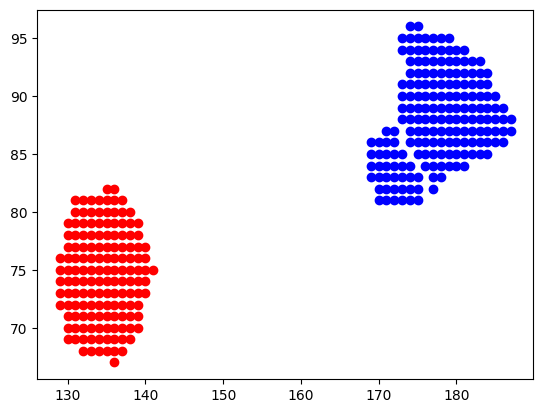

In [10]:
points = gui.data_manager.getDictROICoords("pri").get(0)
points = np.array([points["xpix"], points["ypix"]]).T

plt.scatter(points[:,0], points[:,1], c='r')
plt.scatter(points_reg[:,0], points_reg[:,1], c='b')
plt.show()

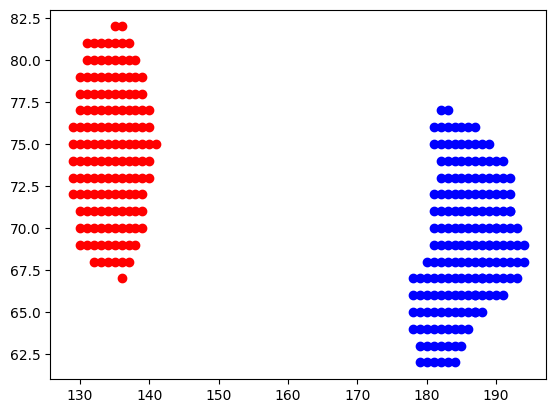

In [12]:
points = gui.data_manager.getDictROICoords("pri").get(0)
points = np.array([points["xpix"], points["ypix"]]).T

plt.scatter(points[:,0], points[:,1], c='r')
plt.scatter(points_reg[:,0], points_reg[:,1], c='b')
plt.show()

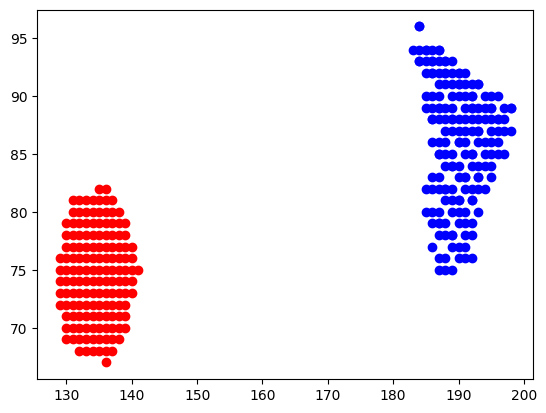

In [14]:
points = gui.data_manager.getDictROICoords("pri").get(0)
points = np.array([points["xpix"], points["ypix"]]).T

plt.scatter(points[:,0], points[:,1], c='r')
plt.scatter(points_reg[:,0], points_reg[:,1], c='b')
plt.show()